Maybe we define new structure which captures the input parameters specific to each problem in one place (`scale_factor`).
We need to define a range on `d` that is also function dependent (that we could adjust by hand). 

We need to generate three graphs: 
- Histogram of Number of `loc_min` points were found, (so outputs of the Optim routine) and what percentage of them is within a small distance of a critical point of the approximant. As a function of the degree `d` of the approximant.


In [1]:
using Pkg
using Revise 
Pkg.activate("../../.")
using Globtim
using DynamicPolynomials, DataFrames
using ProgressLogging
using Optim
# using GLMakie
# GLMakie.activate!()
using CairoMakie
using GeometryBasics
CairoMakie.activate!

  Activating project at `~/globtim`


activate! (generic function with 1 method)

Can a function export "Optional attributes" like just some constants or its optimal domain of definition? --> works. 

In [12]:
params = load_function_params("tref_small")
TR = test_input(tref;
    dim=params.dim,
    center=params.center,
    GN=params.num_samples,
    sample_range=params.sample_range,
)

@polyvar(x[1:TR.dim]); # Define polynomial ring 

function plot_samples(points::Matrix{Float64})
    fig = Figure()
    ax = Axis(fig[1, 1],
        xlabel="x₁",
        ylabel="x₂")
    scatter!(ax, points[:, 1], points[:, 2],
        color=:blue,
        markersize=6,
        alpha=0.8)
    fig
end

plot_samples (generic function with 1 method)

A quick function to actually construct a Polynomial approximant, for plotting purposes. 

In [3]:
d = 14
pol_cheb = Constructor(TR, d, basis=:chebyshev)
w_d = construct_chebyshev_approx(x, pol_cheb.coeffs, d)
grid = pol_cheb.grid;

current L2-norm: 0.0559702995898176


In [4]:
x_range = (-0.2, .9)  # choose x bounds
y_range = (-0.85, 0.85)  # choose y bounds
mask = .!((x_range[1] .<= grid[:, 1] .<= x_range[2]) .&
          (y_range[1] .<= grid[:, 2] .<= y_range[2]))
missing_grid = grid[mask, :];

toy_pol = Toy_gen(tref, TR.dim, d, missing_grid, TR.sample_range)
w_d_missing_samples = construct_chebyshev_approx(x, toy_pol.coeffs, d);

Number of polynomial terms: 120
Condition number of G: 629802.3891934428


In [5]:
x1_range = range(-1,1, length=100)
x2_range = range(-1,1, length=100)

# Create surface plot
f1(x1_val, x2_val) = Float64(w_d(x1_val, x2_val))
f2(x1_val, x2_val) = Float64(w_d_missing_samples(x1_val, x2_val))

# Create matrix of z values
z1 = [f1(x1_val, x2_val) for x1_val in x1_range, x2_val in x2_range]
z2 = [f2(x1_val, x2_val) for x1_val in x1_range, x2_val in x2_range];

## Create the plot ##

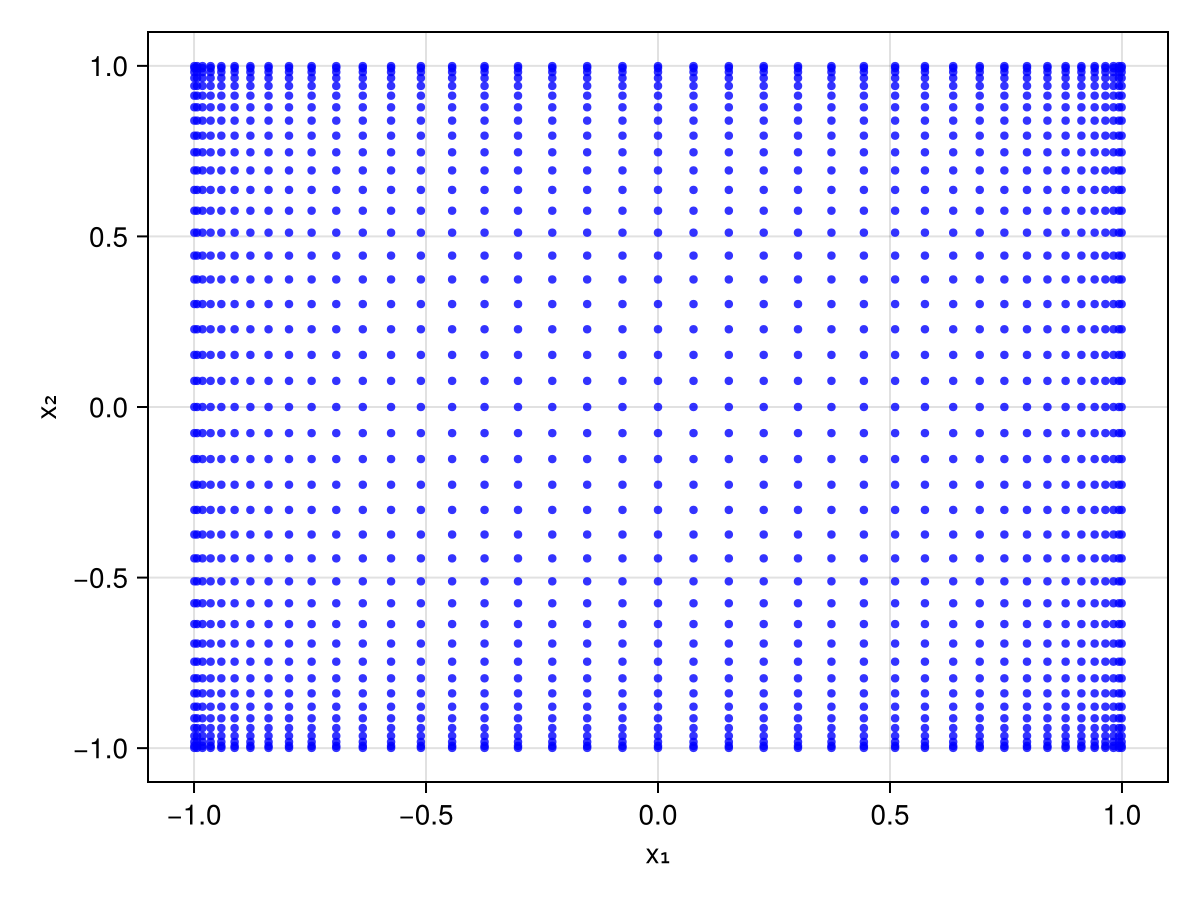

CairoMakie.Screen{PDF}


In [ ]:
fig_1 = plot_samples(grid) # make points larger. 
display(fig_1)
# save("discrete_grid.pdf", fig_1)

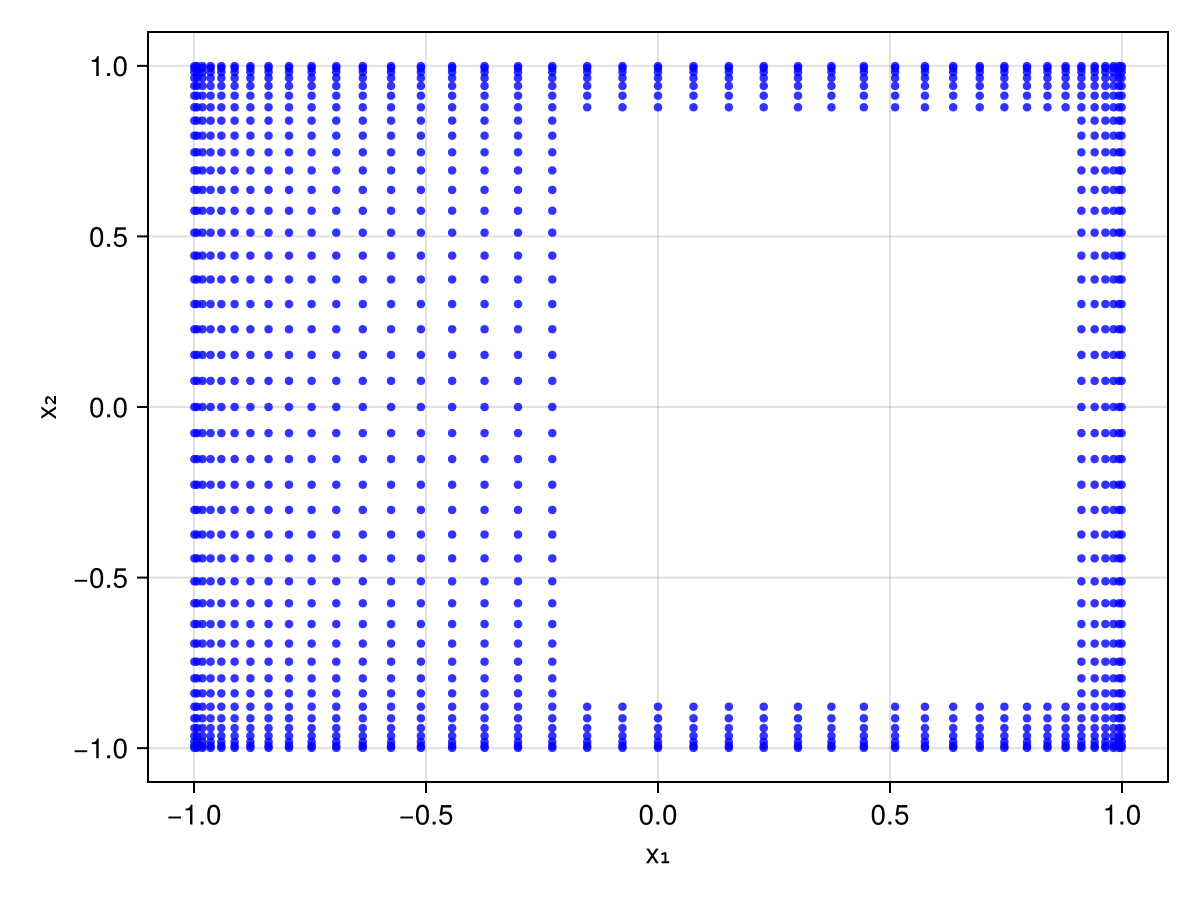

CairoMakie.Screen{IMAGE}


In [ ]:
fig_2 = plot_samples(missing_grid)
# save("discrete_grid_hole.pdf", fig_2)
display(fig_2)

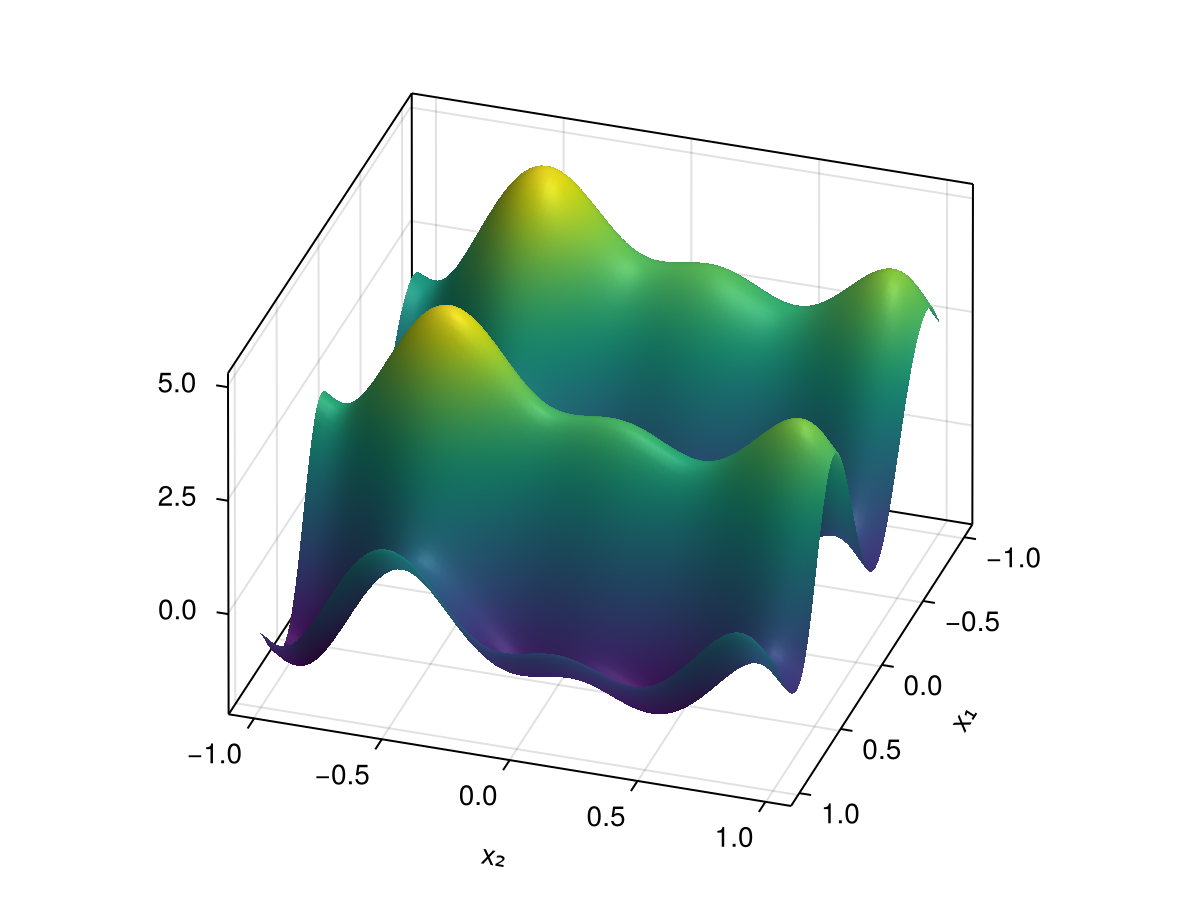

CairoMakie.Screen{IMAGE}


In [8]:
fig_3 = Figure()
ax = Axis3(fig_3[1, 1], xlabel="x₁", ylabel="x₂", zlabel="", azimuth=.1π, elevation=π / 6)
surface!(ax, x1_range, x2_range, z1)
# min_z = minimum(z1)
# surface!(ax, x_range, y_range, fill(min_z, length(x_range), length(y_range)), color=:orange, transparency=true)
display(fig_3)

Add the level set plots for this. 

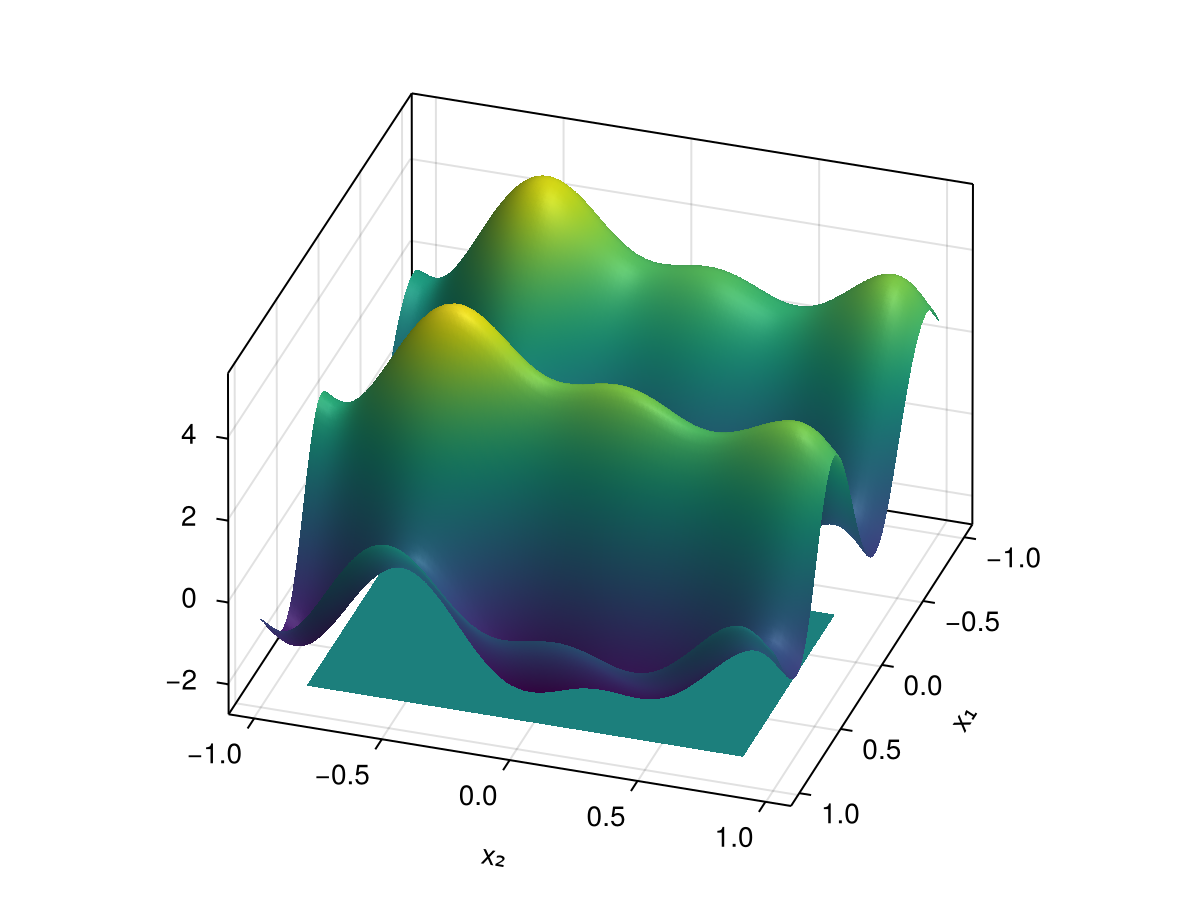

CairoMakie.Screen{IMAGE}


In [9]:
fig_4 = Figure()
ax = Axis3(fig_4[1, 1], xlabel="x₁", ylabel="x₂", zlabel="", azimuth=0.1π, elevation=π / 6)
min_z = minimum(z2)
surface!(ax, x_range, y_range, fill(min_z, length(x_range), length(y_range)), color=:red, transparency=false)
surface!(ax, x1_range, x2_range, z2)
display(fig_4)

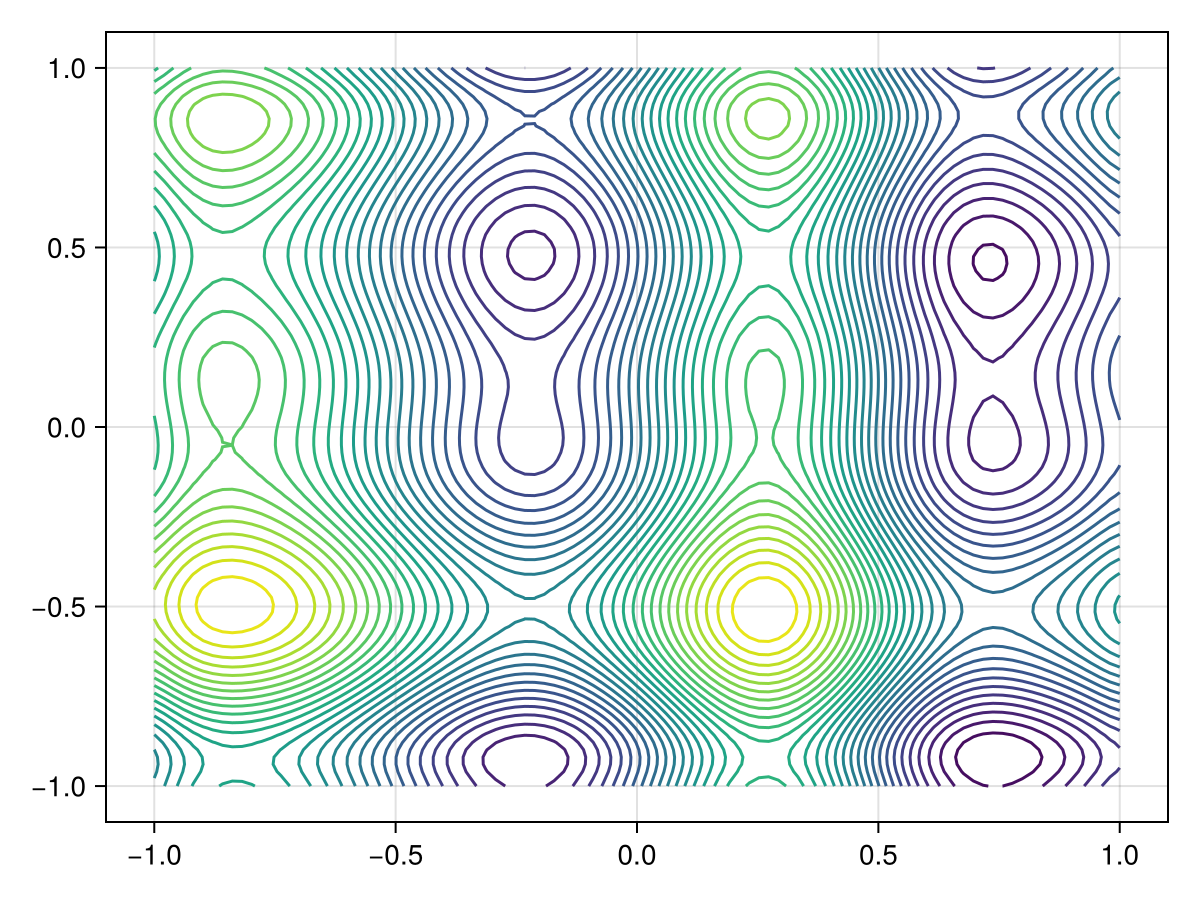

CairoMakie.Screen{PDF}


In [10]:
fig_5 = Figure()
ax = Axis(fig_5[1, 1])

# Create contour plot
contour!(ax, x1_range, x2_range, z1, levels=30, linewidth=1.5)

# Add transparent rectangle overlay
rect_x = [minimum(x1_range), maximum(x1_range), maximum(x1_range), minimum(x1_range)]
rect_y = [minimum(x2_range), minimum(x2_range), maximum(x2_range), maximum(x2_range)]
# poly!(ax, Point2f0[(x_range[1], y_range[1]), (x_range[2], y_range[1]),
#         (x_range[2], y_range[2]), (x_range[1], y_range[2])],
#     color=(:blue, 0.2))

display(fig_5)
save("small_contour_plot.pdf", fig_5)

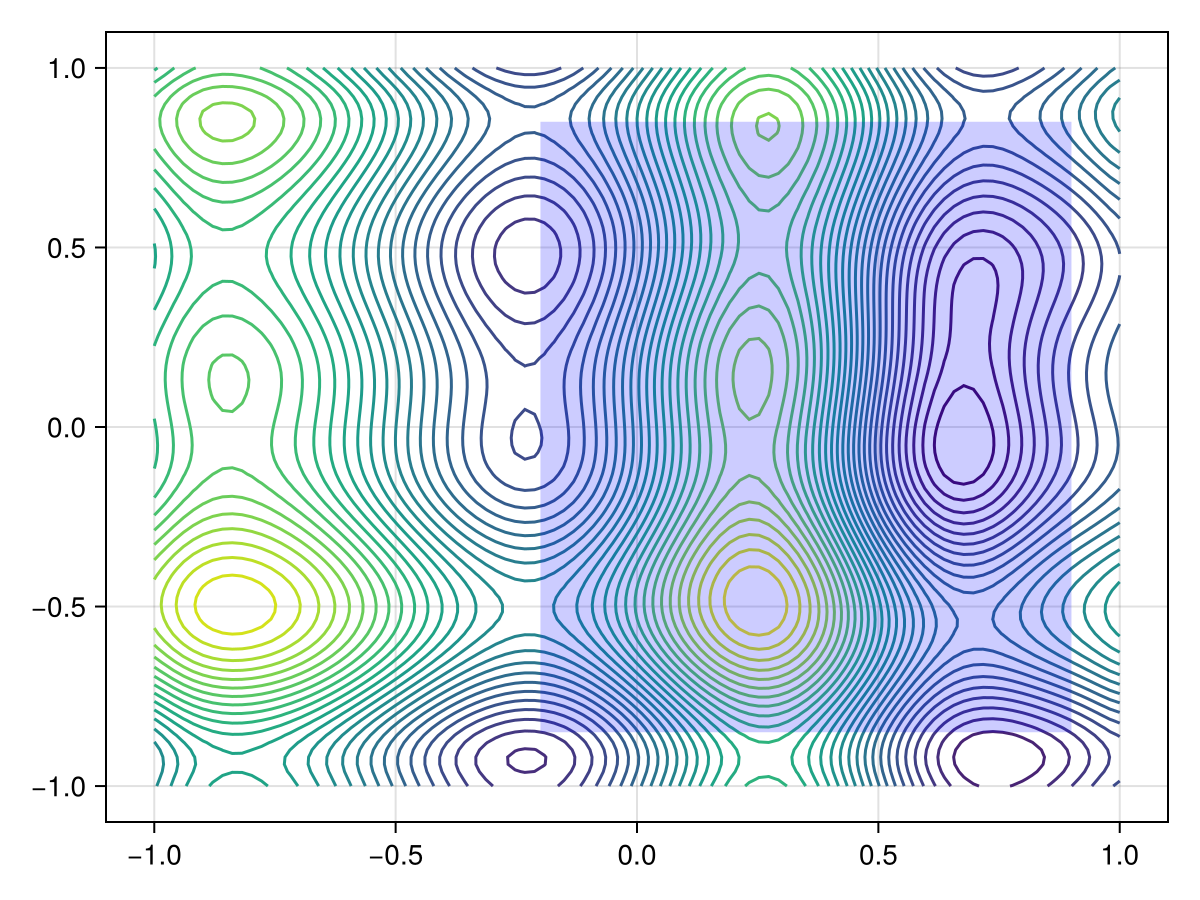

CairoMakie.Screen{PDF}


In [11]:
fig_6 = Figure()
ax = Axis(fig_6[1, 1])

# Create contour plot
contour!(ax, x1_range, x2_range, z2, levels=30, linewidth=1.5)

# Add transparent rectangle overlay
rect_x = [minimum(x1_range), maximum(x1_range), maximum(x1_range), minimum(x1_range)]
rect_y = [minimum(x2_range), minimum(x2_range), maximum(x2_range), maximum(x2_range)]
poly!(ax, Point2f0[(x_range[1], y_range[1]), (x_range[2], y_range[1]),
        (x_range[2], y_range[2]), (x_range[1], y_range[2])],
    color=(:blue, 0.2))

display(fig_6)
save("small_contour_plot_highlight_missing_samples.pdf", fig_6)

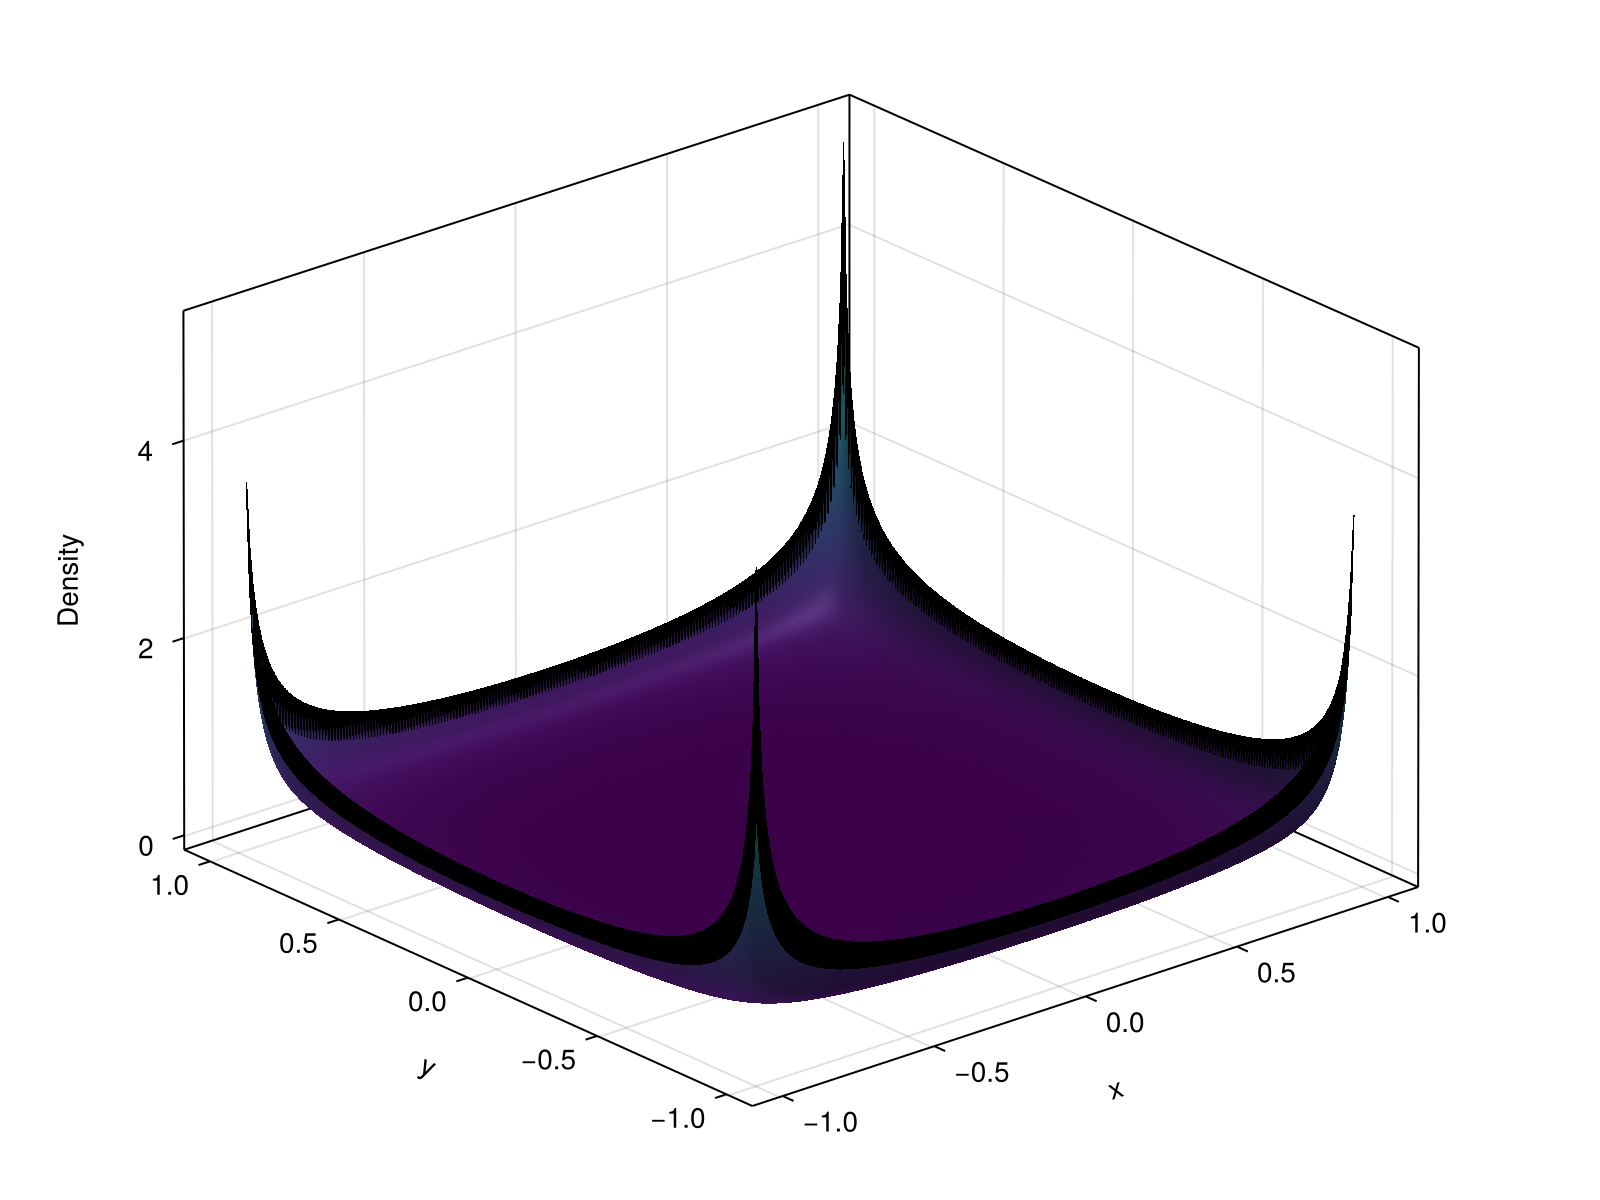

CairoMakie.Screen{IMAGE}


In [12]:
# using CairoMakie
using Distributions

function chebyshev_pdf(x, n)
    if abs(x) > 1
        return 0.0
    else
        return 1.0 / (π * sqrt(1 - x^2))
    end
end

# Create grid points
x = y = range(-1, 1, length=200)
z = zeros(length(x), length(y))

# Calculate combined density
for (i, xi) in enumerate(x)
    for (j, yi) in enumerate(y)
        z[i, j] = chebyshev_pdf(xi, 1) * chebyshev_pdf(yi, 1)
    end
end

# Create plot
fig = Figure(size=(800, 600))
ax = Axis3(fig[1, 1],
    xlabel="x",
    ylabel="y",
    zlabel="Density")

surface!(ax, x, y, z,
    colormap=:viridis
    )

display(fig)
# save("chebyshev_2d_density.png", fig)

In [ ]:
# GLMakie.closeall() 

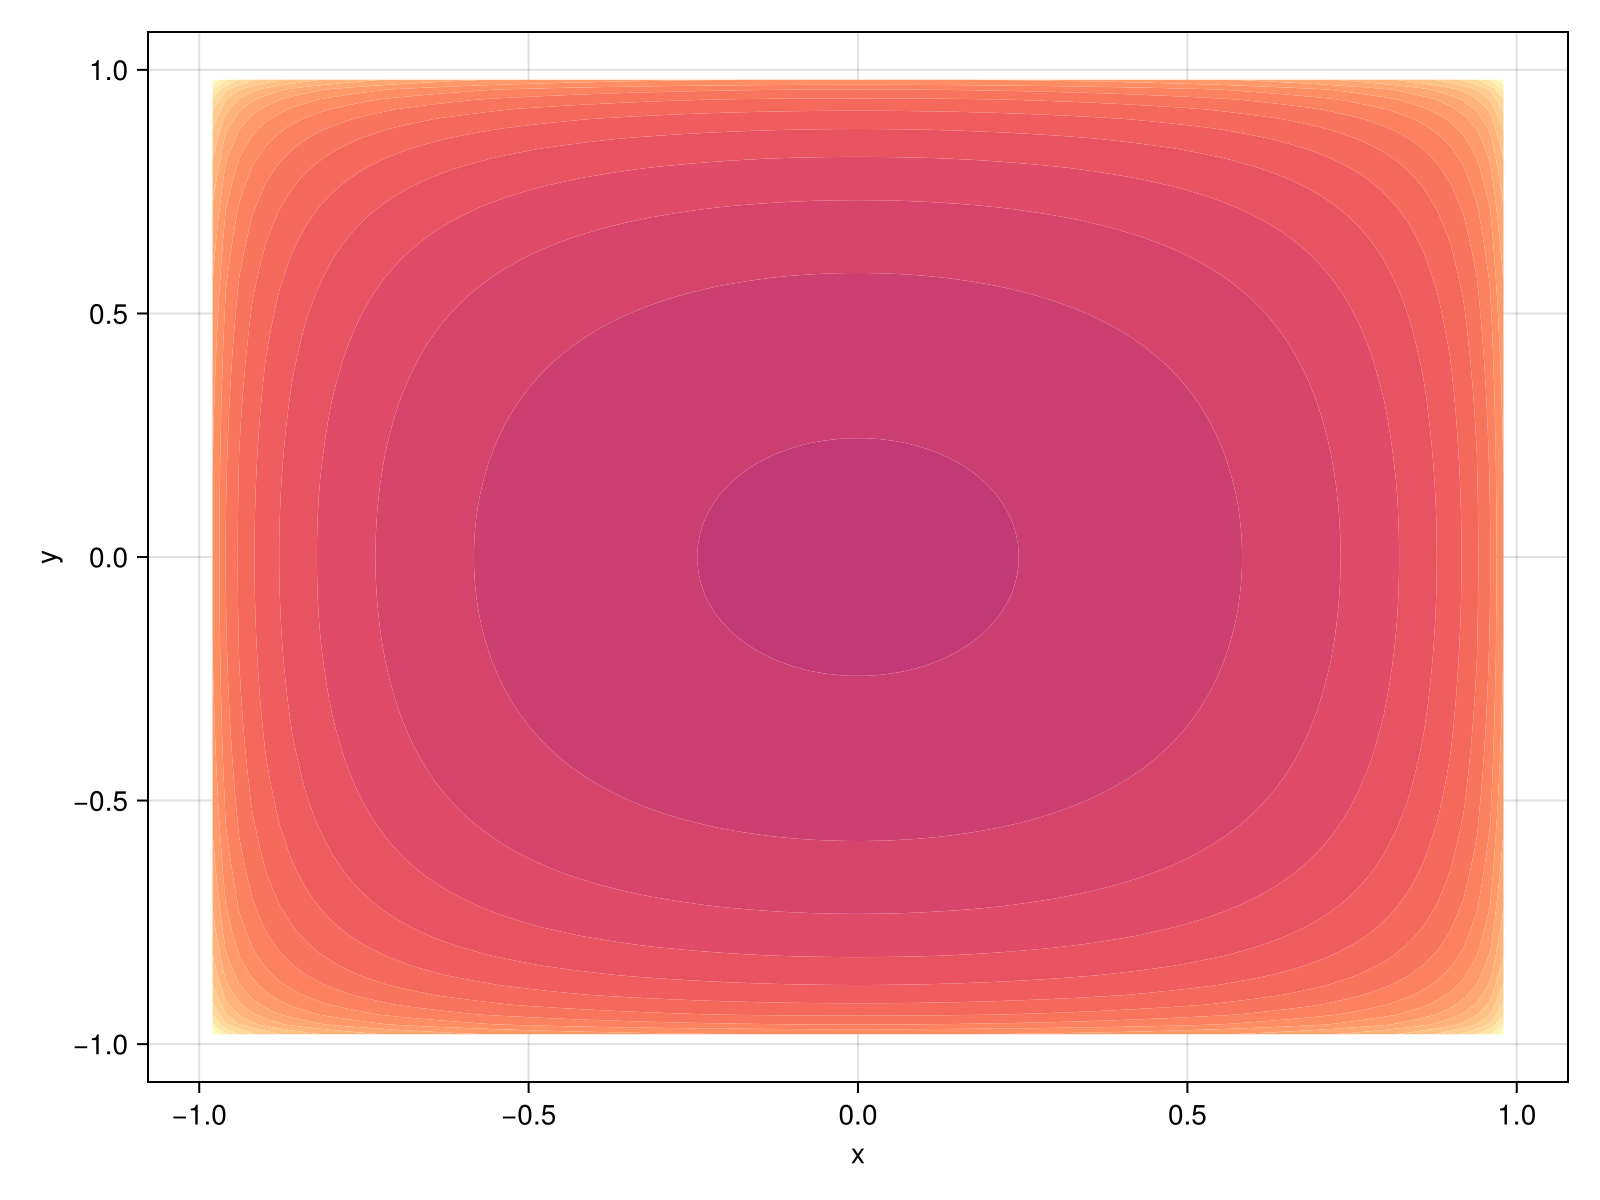

CairoMakie.Screen{IMAGE}


In [ ]:

function chebyshev_pdf(x, n)
    if abs(x) > 1
        return 0.0
    else
        return 1.0 / (π * sqrt(1 - x^2))
    end
end

x = y = range(-1, 1, length=100)
z = [chebyshev_pdf(xi, 1) * chebyshev_pdf(yi, 1) for xi in x, yi in y]

fig = Figure(size=(800, 600))
ax = Axis(fig[1, 1], xlabel="x", ylabel="y")
z_scaled = z ./ maximum(filter(isfinite, z))

levels = exp10.(range(log10(1e-3), log10(1.0), 40))

contourf!(ax, x, y, z_scaled, levels=levels, colormap=:magma)

display(fig)
# save("chebyshev_contour.pdf", fig)

In [9]:
# d_min, d_max = 2, 10
# results = analyze_degrees(TR, x, d_min, d_max, step=1, tol_dist=0.5)

current L2-norm: 2.9544194049643253
Dimension m of the vector space: 6

=== Starting MSolve Parser (dimension: 2) ===
Processed 1 points (0.0s)
No valid points found after filtering
current L2-norm: 2.4369400396182805
Dimension m of the vector space: 10

=== Starting MSolve Parser (dimension: 2) ===
Processed 0 points (0.0s)
No valid points found after filtering
current L2-norm: 2.375184110252418
Dimension m of the vector space: 15

=== Starting MSolve Parser (dimension: 2) ===
Processed 7 points (0.0s)
Processing point 1 of 2
Optimization status: ✗ (outside bounds)
Processing point 2 of 2
Optimization status: ✗ (outside bounds)
current L2-norm: 1.1669296482333935
Dimension m of the vector space: 21

=== Starting MSolve Parser (dimension: 2) ===
Processed 16 points (0.0s)
Processing point 1 of 12
Optimization status: ✗ (outside bounds)
Processing point 2 of 12
Optimization has converged within bounds: ✓
Processing point 3 of 12
Optimization status: ✗ (outside bounds)
Processing point 4

Dict{Int64, @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedTuple, discrete_l2::Float64}} with 9 entries:
  5  => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  4  => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  6  => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  7  => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  2  => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  10 => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  9  => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  8  => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  3  => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…

In [7]:
PC = results[5]

@NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedTuple, discrete_l2::Float64}((12×8 DataFrame
 Row │ x1          x2          z           y1           y2            close  s ⋯
     │ Float64     Float64     Float64     Float64      Float64       Bool   F ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │  0.0279974  -0.0450321   4.92869      0.566037     1.31994     false    ⋯
   2 │  0.0841548  -0.0446967   0.791105     0.0742373   -0.00517354   true
   3 │ -0.0302288  -0.0437004   1.30236     -0.0244031    0.210612     true
   4 │ -0.0857836  -0.0412286   4.73961    NaN          NaN           false
   5 │  0.0836891   0.0305739  -1.13115      0.0723702    0.127519     true    ⋯
   6 │  0.028439    0.0330908   2.75525     -0.0244031    0.210612     true
   7 │ -0.0862986   0.033377    2.99316     -1.17038      0.863282    false
   8 │ -0.0295529   0.034218   -0.848868    -0.0222934    0.0472676    true
   9 │ -0.0864193   0.08

In [40]:
new_results = analyze_degrees(TR, x, d_min, d_max, results, tol_dist=1.)

Dict{Int64, @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedTuple, discrete_l2::Float64}} with 11 entries:
  16 => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  20 => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  12 => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  24 => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  28 => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  30 => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  22 => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  14 => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  10 => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  18 => @NamedTuple{df::DataFrame, df_min::DataFrame, convergence_stats::NamedT…
  26 => @NamedTuple{df::DataFrame, df_min::DataFrame, converg

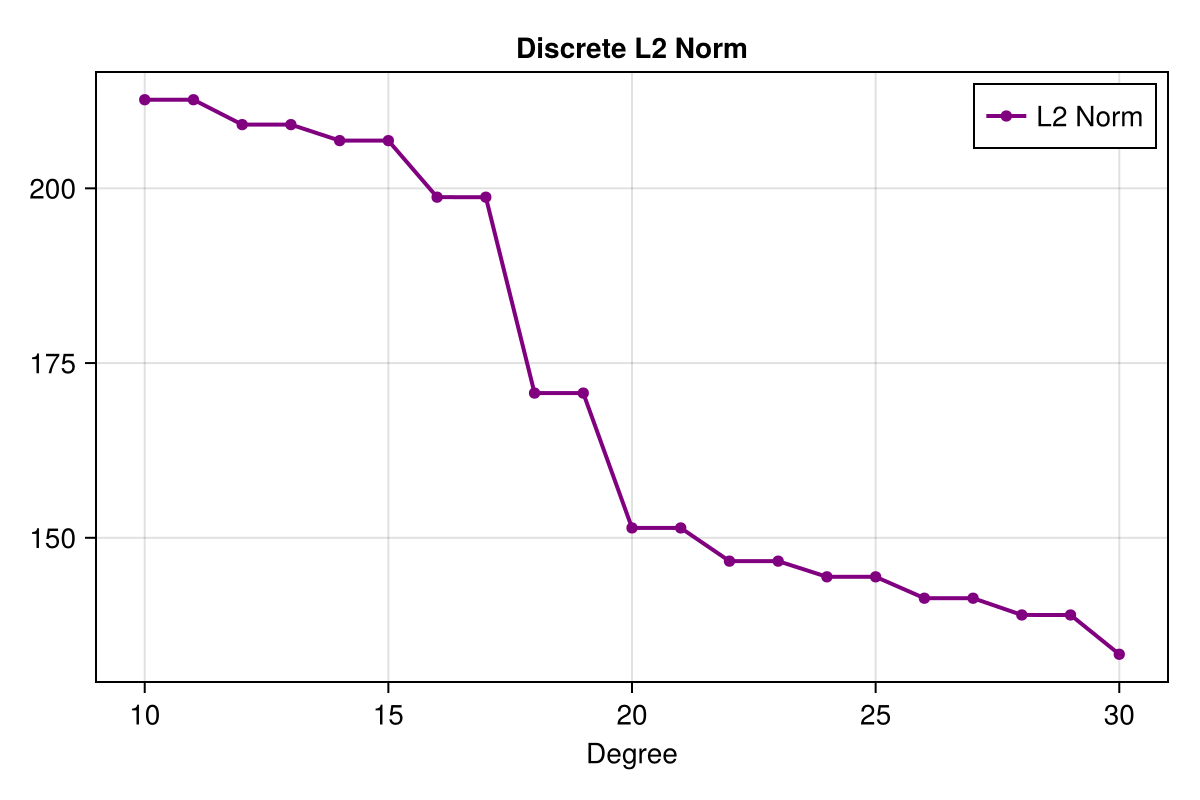

CairoMakie.Screen{IMAGE}


In [28]:
fig_1 = plot_discrete_l2(results, d_min, d_max, 1)
# save("discrete_l2.pdf", fig_1)
display(fig_1)

In [39]:
fig_2 = capture_histogram(new_results, d_min, d_max, 1, show_legend=false)
# save("histogram.pdf", fig_2)
display(fig_2)

KeyError: KeyError: key 11 not found

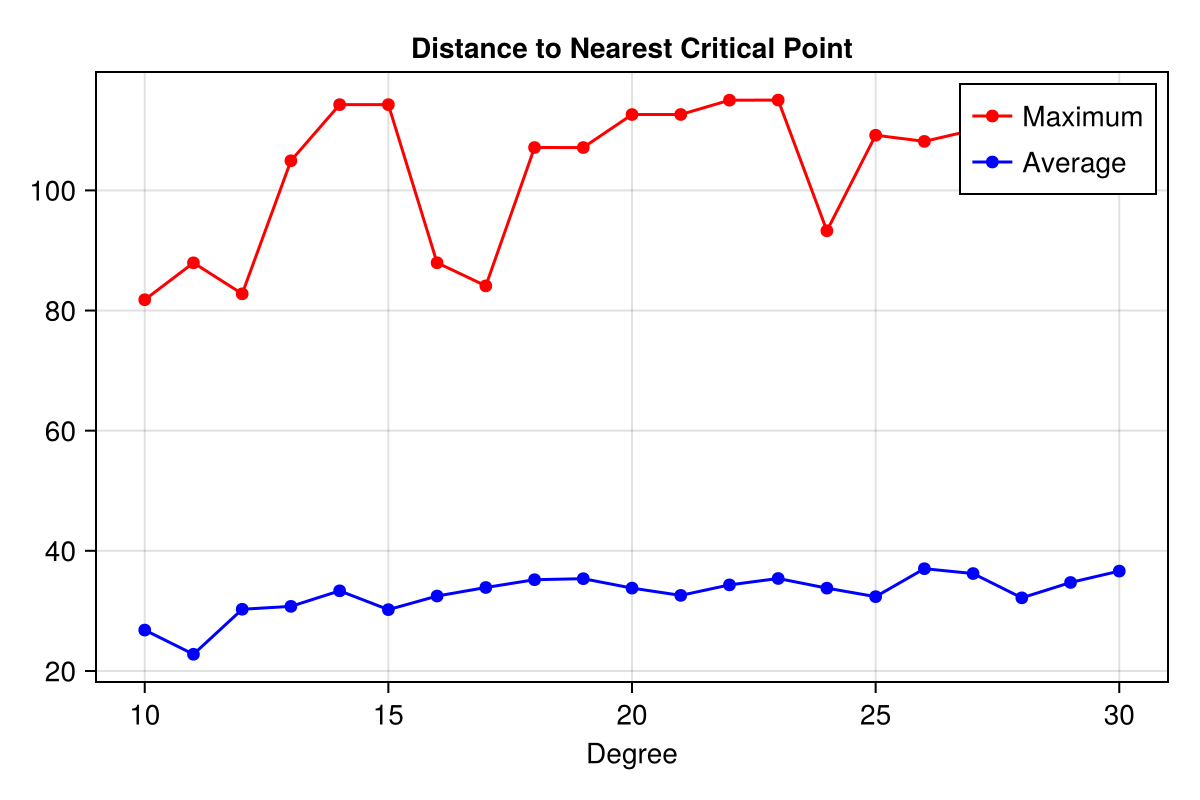

CairoMakie.Screen{IMAGE}


In [31]:
fig_3 = plot_convergence_analysis(results, d_min, d_max, 1)
# save("convergence_analysis.pdf", fig_3)
display(fig_3)